# Introduction to Fugue


<img src="img/fugue_architecture.png" align="center" width="800"/>

## PyCaret

[PyCaret](https://github.com/pycaret/pycaret) is a low code machine learning framework that automates a lot of parts of the machine learning pipeline. With just a few lines of code, several models can be trained on a dataset. In this post, we explore how to scale this capability by running several PyCaret training jobs in a distributed manner on Spark or Dask.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pycaret.datasets import get_data
df = get_data('titanic')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
from pycaret.classification import *
clf = setup(data = df, target = 'Survived', session_id=123, silent = True, verbose=False, html=False)
models = compare_models(fold = 3, sort = "Accuracy", turbo = True, verbose=False)
results = pull().reset_index(drop=True)
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Ada Boost Classifier,0.8154,0.8523,0.7215,0.7901,0.7536,0.6066,0.6088,0.6467
1,Decision Tree Classifier,0.8122,0.7988,0.7375,0.7739,0.7539,0.6024,0.6041,0.0500
2,Ridge Classifier,0.8122,0.0000,0.7296,0.7774,0.7527,0.6016,0.6024,0.0533
3,Gradient Boosting Classifier,0.8090,0.8551,0.6802,0.8039,0.7361,0.5881,0.5938,0.1433
4,Logistic Regression,0.8074,0.8578,0.7215,0.7717,0.7455,0.5909,0.5920,2.3300
5,Random Forest Classifier,0.7978,0.8444,0.6640,0.7889,0.7202,0.5637,0.5695,0.1400
6,Light Gradient Boosting Machine,0.7945,0.8535,0.6885,0.7651,0.7242,0.5612,0.5637,0.2200
7,Extra Trees Classifier,0.7898,0.8470,0.6598,0.7707,0.7100,0.5469,0.5516,0.1400
8,SVM - Linear Kernel,0.7110,0.0000,0.5530,0.6604,0.5912,0.3739,0.3830,0.5933
9,K Neighbors Classifier,0.7062,0.7331,0.5818,0.6402,0.6071,0.3738,0.3767,0.7267


## Wrapping Logic in Function

In [4]:
def wrapper(df: pd.DataFrame) -> pd.DataFrame:
    clf = setup(data = df, 
                target = 'Survived', 
                session_id=123, 
                silent = True, 
                verbose=False, 
                html=False)
    models = compare_models(fold = 3,  
                            sort = "Accuracy", 
                            turbo = True, 
                            verbose=False)
    results = pull().reset_index(drop=True)

    return pd.DataFrame(dict(model=results["Model"], 
                             accuracy=results["Accuracy"], 
                             auc=results["AUC"], 
                             recall=results["Recall"],
                             precision=results["Prec."],
                             f1=results["F1"],
                             time=results["TT (Sec)"]))

## Fugue Transform

In [5]:
from fugue import transform
import pandas as pd

schema = """model:str, accuracy:float, auc:float, recall:float, precision:float, 
f1:float, time:float"""

res = transform(df, wrapper, schema=schema)
res[0:5]

,model,accuracy,auc,recall,precision,f1,time
0,Ada Boost Classifier,0.8154,0.8523,0.7215,0.7901,0.7536,0.0933
1,Decision Tree Classifier,0.8122,0.7988,0.7375,0.7739,0.7539,0.0533
2,Ridge Classifier,0.8122,0.0000,0.7296,0.7774,0.7527,0.0600
3,Gradient Boosting Classifier,0.8090,0.8551,0.6802,0.8039,0.7361,0.1233
4,Logistic Regression,0.8074,0.8578,0.7215,0.7717,0.7455,0.1467


## Partition Male and Female

In [6]:
schema = """sex:str, model:str, accuracy:float, auc:float, recall:float, precision:float, 
f1:float, time:float"""

def partitioned_wrapper(df: pd.DataFrame) -> pd.DataFrame:
    clf = setup(data = df, 
                target = 'Survived', 
                session_id=123, 
                silent = True, 
                verbose=False, 
                html=False)
    models = compare_models(fold = 3,  
                            sort = "Accuracy", 
                            turbo = True, 
                            verbose=False)
    results = pull().reset_index(drop=True)

    return pd.DataFrame(dict(sex=df.iloc[0]["Sex"],
                             model=results["Model"], 
                             accuracy=results["Accuracy"], 
                             auc=results["AUC"], 
                             recall=results["Recall"],
                             precision=results["Prec."],
                             f1=results["F1"],
                             time=results["TT (Sec)"]))

In [7]:
res = transform(df, partitioned_wrapper, schema=schema, partition={"by":"Sex"})
res.sort_values("accuracy")[0:5]

,sex,model,accuracy,auc,recall,precision,f1,time
27,male,Naive Bayes,0.2556,0.5118,0.9368,0.2026,0.3332,0.0100
13,female,SVM - Linear Kernel,0.3836,0.0000,0.2242,0.8821,0.3298,0.0100
12,female,Naive Bayes,0.4795,0.8623,0.3212,0.9668,0.4716,0.0100
26,male,Quadratic Discriminant Analysis,0.5207,0.4636,0.3666,0.1648,0.2105,0.0167
11,female,Quadratic Discriminant Analysis,0.6073,0.5214,0.6909,0.7815,0.7060,0.0133


## Bringing to Spark

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

22/08/17 02:50:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/17 02:50:04 WARN MetricsSystem: Using default name SparkStatusTracker for source because neither spark.metrics.namespace nor spark.app.id is set.


In [9]:
res = transform(df.replace({np.nan: None}), 
                partitioned_wrapper, 
                schema=schema, 
                partition={"by":"Sex"}, 
                engine=spark,
                save_path="/tmp/results.parquet")

View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi
View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


## FugueSQL

In [10]:
%%fsql spark
LOAD "/tmp/results.parquet"
PRINT

View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


,sex,model,accuracy,auc,recall,precision,f1,time
0,female,Ridge Classifier,0.8630,0.0000,0.9074,0.9077,0.9074,0.0200
1,female,Extra Trees Classifier,0.8402,0.9077,0.9198,0.8741,0.8945,0.3633
2,female,Logistic Regression,0.8311,0.8938,0.9198,0.8634,0.8898,1.3267
3,female,Gradient Boosting Classifier,0.8128,0.8739,0.8951,0.8582,0.8762,0.1267
4,female,Random Forest Classifier,0.8082,0.8936,0.9198,0.8376,0.8754,0.3533
5,female,Light Gradient Boosting Machine,0.8082,0.8819,0.8889,0.8592,0.8721,0.0500
6,female,Decision Tree Classifier,0.8037,0.7251,0.8889,0.8520,0.8697,0.0600
7,female,Ada Boost Classifier,0.7991,0.8127,0.8642,0.8661,0.8648,0.1633
8,female,Dummy Classifier,0.7397,0.5000,1.0000,0.7397,0.8504,0.0167
9,female,SVM - Linear Kernel,0.7260,0.0000,0.9753,0.7382,0.8402,0.0200


In [11]:
%%fsql spark
df = LOAD "/tmp/results.parquet"

SELECT sex, AVG(time) AS time
  FROM df
 GROUP BY sex
 PRINT

View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


,sex,time
0,female,0.187850
1,male,0.124514


In [12]:
%%fsql spark
df = LOAD "/tmp/results.parquet"

TAKE 5 ROWS FROM df PREPARTITION BY sex PRESORT auc DESC
YIELD LOCAL DATAFRAME AS result

View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


View job details at https://dbc-fd3c27a3-594d.cloud.databricks.com/?o=2707332449367147#/setting/clusters/0804-155157-zq2rzdv4/sparkUi


In [13]:
result.native

,sex,model,accuracy,auc,recall,precision,f1,time
0,female,Extra Trees Classifier,0.8402,0.9077,0.9198,0.8741,0.8945,0.3633
1,female,Naive Bayes,0.4201,0.9053,0.2160,1.0000,0.3537,0.0233
2,female,Logistic Regression,0.8311,0.8938,0.9198,0.8634,0.8898,1.3267
3,female,Random Forest Classifier,0.8082,0.8936,0.9198,0.8376,0.8754,0.3533
4,female,Light Gradient Boosting Machine,0.8082,0.8819,0.8889,0.8592,0.8721,0.0500
5,male,Gradient Boosting Classifier,0.8412,0.6912,0.1304,0.6825,0.2137,0.1800
6,male,Logistic Regression,0.8288,0.6779,0.0580,0.3556,0.0989,0.2233
7,male,Random Forest Classifier,0.8263,0.6706,0.1014,0.4349,0.1621,0.3900
8,male,Light Gradient Boosting Machine,0.8312,0.6463,0.2464,0.4905,0.3179,0.0833
9,male,Extra Trees Classifier,0.8362,0.6462,0.1739,0.5667,0.2616,0.3200


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
def plotter(df:pd.DataFrame) -> None:

    fig = plt.figure(figsize=(12,10))
    ax = sns.scatterplot(x=df["precision"],y=df["recall"],hue=df["sex"])
    # The magic starts here:
    for line in range(0,df.shape[0]):
         ax.text(df["precision"].iloc[line]+0.01, df["recall"].iloc[line], 
                 df["model"].iloc[line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')

    plt.title('Precision and Recall')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

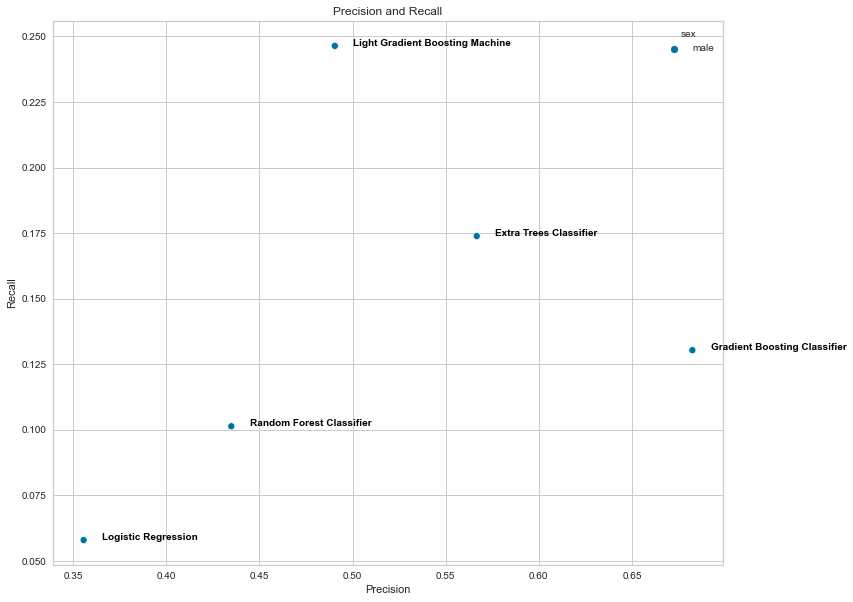

In [15]:
%%fsql
SELECT * 
  FROM result
 WHERE sex = 'male'

OUTPUT USING plotter